# Score the same set of PDBs with different Rosetta builds

## Import Python modules

In [1]:
import os
import sys
import pandas
import glob
import random
import math
import numpy as np
import scipy.stats
import umap
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(font_scale=2, style='ticks', palette='colorblind')

sys.path.append('scripts/')
import design_utils

resultsdir = 'results_250530/'
if not os.path.isdir(resultsdir):
    os.makedirs(resultsdir)

## Score structures

In [2]:
pdbs = glob.glob(os.path.join(
    '/home/dimaio/optE2/dualoptE/decoys/xtal_refine_beta16/',
    '*_clean_0001.pdb'
))
output_dir = os.path.join(
    resultsdir,
    'test_scoring/'
)
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)
file_listing_pdbs = os.path.join(
    output_dir,
    'pdbs_to_test_scoring.txt'
)
if not os.path.isfile(file_listing_pdbs):
    with open(file_listing_pdbs, 'w') as f:
        for pdb in pdbs:
            f.write(f'{pdb}\n')

In [3]:
score_app_paths = {
    'v1' : '/home/haddox/Rosetta/main/source/bin/score.default.linuxgccrelease',
    # 'v1_per_res' : '/home/haddox/Rosetta/main/source/bin/per_residue_energies.default.linuxgccrelease',
    # 'v2' : '/home/haddox/Rosetta_optE/main/source/bin/score.default.linuxgccrelease',
    # 'v3' : '/software/rosetta/latest/main/source/bin/score.hdf5.linuxgccrelease',
    # 'v4' : '/software/rosetta/versions/v2019.01-dev60566/main/source/bin/score.hdf5.linuxgccrelease',
}
e_functions_dict = {
    'beta_nov16' : {
        'weights_file' : 'beta_nov16',
        'flags_file' : None,
        'extra_args' : [
            f'-beta_nov16',
            f'-corrections::beta_nov16',
        ],
    },
    'beta_nov16_cart' : {
        'weights_file' : 'beta_nov16_cart',
        'flags_file' : None,
        'extra_args' : [
            f'-beta_nov16_cart',
            f'-corrections::beta_nov16',
        ],
    },
    
    'beta_nov16_cart_from_files' : {
        'weights_file' : \
            'data/beta_nov16_cart.wts',
        'flags_file' : \
            'data/flags_beta16',
        'extra_args' : [],
    },
    
    'beta_nov16_cart_nostab_refit_from_files' : {
        'weights_file' : \
            'data/beta16.nostab-refit_cart.wts',
        'flags_file' : \
            'data/flags_beta16',
        'extra_args' : [],
    },
    
    'beta_nov16_nostab_from_files' : {
        'weights_file' : \
            'data/beta16.nostab_torsion.wts',
        'flags_file' : \
            'data/flags_beta16',
        'extra_args' : [],
    },
    'beta_nov16_nostab_refit_from_files' : {
        'weights_file' : \
            'data/beta16.nostab-refit_torsion.wts',
        'flags_file' : \
            'data/flags_beta16',
        'extra_args' : [],
    },
    'beta_dec20' : {
        'weights_file' : 'beta_dec20',
        'flags_file' : None,
        'extra_args' : [
            f'-beta_dec20',
            f'-corrections::beta_dec20',
        ],
    },
    'beta_dec20_cart' : {
        'weights_file' : 'beta_dec20_cart',
        'flags_file' : None,
        'extra_args' : [
            f'-beta_dec20_cart',
            f'-corrections::beta_dec20',
        ],
    },
    '19A' : {
        'weights_file' : \
            'data/HH_run19A_weights_266_torsional_space.wts',
        'flags_file' : \
            'data/HH_run19A_flags_266',
        'extra_args' : [],
    },
    '19A_cart' : {
        'weights_file' : \
            'data/HH_run19A_weights_266.wts',
        'flags_file' : \
            'data/HH_run19A_flags_266',
        'extra_args' : [],
    },
    '19A_cart_revert_H2O_params' : {
        'weights_file' : \
            'data/HH_run19A_weights_266.wts',
        'flags_file' : \
            'data/HH_run19A_flags_266_revert_H2O_params',
        'extra_args' : [],
    },
}
e_functions = [
    # 'beta_nov16',
    'beta_nov16_cart',
    'beta_nov16_cart_from_files',
    # 'beta_dec20',
    # 'beta_dec20_cart',
    # '19A',
    # '19A_cart',
    # '19A_cart_revert_H2O_params',
]
vs = [
    'v1', # 'v1_per_res'
    # 'v2', 'v3', #'v4',
]
for e_function in e_functions:
    for v in vs:
        output_dir = os.path.join(
            resultsdir,
            'test_scoring',
            f'{e_function}_{v}/',
        )
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
            scores_file_prefix = os.path.join(output_dir, 'scores')
            score_app_path = score_app_paths[v]
            weights_file = e_functions_dict[e_function]['weights_file']
            flags_file = e_functions_dict[e_function]['flags_file']
            extra_args = list(e_functions_dict[e_function]['extra_args'])
            extra_args += [
                '-read_only_ATOM_entries'
            ]
            if 'per_res' in v:
                silent_scores_file = f'{scores_file_prefix}_per_res.sc'
                extra_args += [
                    f'-out:file:silent {silent_scores_file}'
                ]
            design_utils.compute_score_using_rosettascripts(
                score_app_path,
                weights_file=weights_file,
                flags_file=flags_file,
                output_dir=output_dir,
                scores_file_prefix=scores_file_prefix,
                file_listing_pdbs=file_listing_pdbs,
                extra_args=extra_args,
                queue_type='cpu',
            )

Read in scores

In [4]:
dfs = []
e_functions = [
    # 'beta_nov16',
    # 'beta_nov16_cart',
    # 'beta_dec20',
    # 'beta_dec20_cart',
    # '19A',
    # '19A_cart',
    # '19A_cart_revert_H2O_params',
    'beta_nov16_cart',
    'beta_nov16_cart_from_files',
]
for e_function in e_functions:
    for v in vs:
        scores_f = os.path.join(
            resultsdir,
            'test_scoring',
            f'{e_function}_{v}',
            'scores.sc'
        )
        if not os.path.isfile(scores_f):
            continue
        df = pandas.read_csv(scores_f, sep='\s+')
        df['e_function'] = e_function
        df['v'] = v
        df['group'] = f'{e_function}_{v}'
        df['pdb'] = df['description'].apply(os.path.basename)
        dfs.append(df)
df = pandas.concat(dfs, sort=False)
df.set_index(['e_function', 'v'], inplace=True)
df.sort_index(inplace=True)

In [15]:
df['score'].describe()

count    156.000000
mean    -227.936571
std      133.699127
min     -400.135000
25%     -306.606000
50%     -238.323500
75%     -168.825000
max      685.076000
Name: score, dtype: float64

In [10]:
df.columns.values

array(['SCORE:', 'score', 'fa_atr', 'fa_rep', 'fa_sol',
       'fa_intra_atr_xover4', 'fa_intra_rep_xover4',
       'fa_intra_sol_xover4', 'lk_ball', 'lk_ball_iso', 'lk_ball_bridge',
       'lk_ball_bridge_uncpl', 'fa_elec', 'fa_intra_elec', 'hbond_sr_bb',
       'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13', 'omega',
       'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'p_aa_pp', 'hxl_tors',
       'ref', 'rama_prepro', 'cart_bonded', 'allatom_rms', 'gdtmm',
       'gdtmm1_1', 'gdtmm2_2', 'gdtmm3_3', 'gdtmm4_3', 'gdtmm7_4', 'irms',
       'maxsub', 'maxsub2.0', 'rms', 'description', 'group', 'pdb'],
      dtype=object)

In [11]:
terms = [
    # 'score', 'fa_atr', 'fa_rep', 'ref'
    'score',
    'fa_atr', 'fa_rep', 'fa_sol',
    'fa_intra_atr_xover4', 'fa_intra_rep_xover4',
    'fa_intra_sol_xover4', 'lk_ball', 'lk_ball_iso', 'lk_ball_bridge',
    'lk_ball_bridge_uncpl', 'fa_elec', 'fa_intra_elec', 'hbond_sr_bb',
    'hbond_lr_bb', 'hbond_bb_sc', 'hbond_sc', 'dslf_fa13', 'omega',
    'fa_dun_dev', 'fa_dun_rot', 'fa_dun_semi', 'p_aa_pp', 'hxl_tors',
    'ref', 'rama_prepro', 'cart_bonded'
]
groups = ('beta_nov16_cart_v1', 'beta_nov16_cart_from_files_v1')
for term in terms:
    data = df.pivot(values=term, columns='group', index='pdb')
    data['diff'] = data[groups[1]] - data[groups[0]]
    print(term, set(data['diff']))

score {0.0009999999999763531, 0.0010000000000047748, 0.0010000000000331966, 0.0, 0.00100000000009004}
fa_atr {0.0}
fa_rep {0.0}
fa_sol {0.0010000000000047748, 0.0009999999999763531, 0.0010000000000331966, 0.0, 0.00100000000009004}
fa_intra_atr_xover4 {0.0}
fa_intra_rep_xover4 {0.0}
fa_intra_sol_xover4 {0.0, 0.0009999999999976694}
lk_ball {0.0, 0.0010000000000047748, 0.0010000000000331966, 0.0009999999999763531}
lk_ball_iso {0.0, -0.0010000000000331966, -0.0010000000000047748, -0.0009999999999763531}
lk_ball_bridge {0.0}
lk_ball_bridge_uncpl {0.0}
fa_elec {0.0}
fa_intra_elec {0.0}
hbond_sr_bb {0.0}
hbond_lr_bb {0.0}
hbond_bb_sc {0.0}
hbond_sc {0.0}
dslf_fa13 {0.0}
omega {0.0}
fa_dun_dev {0.0}
fa_dun_rot {0.0}
fa_dun_semi {0.0}
p_aa_pp {0.0}
hxl_tors {0.0}
ref {0.0}
rama_prepro {0.0}
cart_bonded {0.0}


In [12]:
data = df.pivot(values='score', columns='group', index='pdb')
groups_to_analyze = [
    ('beta_nov16_cart_v1', 'beta_nov16_cart_from_files_v1'),
    # ('beta_nov16_v2', 'beta_nov16_v3'),
    # ('beta_nov16_cart_v1', 'beta_nov16_cart_v3'),
    # ('19A_v2', 'beta_dec20_v2'),
    # ('19A_cart_v2', 'beta_dec20_cart_v2'),
    # ('beta_nov16_v2', 'beta_dec20_cart_v2'),
]
#groups = ('19A_cart_v1', '19A_cart_revert_H2O_params_v1')
for groups in groups_to_analyze:
    print(groups)
    data['diff'] = data[groups[1]] - data[groups[0]]
    print(set(data['diff']))

('beta_nov16_cart_v1', 'beta_nov16_cart_from_files_v1')
{0.0009999999999763531, 0.0010000000000047748, 0.0010000000000331966, 0.0, 0.00100000000009004}


In [13]:
data['diff'].value_counts()

0.000    53
0.001    12
0.001     7
0.001     5
0.001     1
Name: diff, dtype: int64

In [7]:
data

group,beta_nov16_cart_from_files_v1,beta_nov16_cart_v1,diff
pdb,,,
1aho_clean_0001_0001,-103.857,-103.858,0.001
1b9o_clean_0001_0001,-224.525,-224.526,0.001
1bkr_clean_0001_0001,-241.359,-241.360,0.001
1bq8_clean_0001_0001,-134.540,-134.540,0.000
1c7k_clean_0001_0001,-343.992,-343.993,0.001
1cxq_clean_0001_0001,-352.314,-352.314,0.000
1d4t_clean_0001_0001,-315.013,-315.014,0.001
1euw_clean_0001_0001,-247.707,-247.707,0.000
1f94_clean_0001_0001,-94.657,-94.657,0.000


In [47]:
data = df.pivot(values='score', columns='group', index='pdb')
groups_to_analyze = [
    ('beta_nov16_v1', 'beta_nov16_v3'),
    ('beta_nov16_v2', 'beta_nov16_v3'),
    ('beta_nov16_cart_v1', 'beta_nov16_cart_v3'),
    ('19A_v2', 'beta_dec20_v2'),
    ('19A_cart_v2', 'beta_dec20_cart_v2'),
    ('beta_nov16_v2', 'beta_dec20_cart_v2'),
]
#groups = ('19A_cart_v1', '19A_cart_revert_H2O_params_v1')
for groups in groups_to_analyze:
    print(groups)
    data['diff'] = data[groups[1]] - data[groups[0]]
    print(set(data['diff']))

('beta_nov16_v1', 'beta_nov16_v3')
{0.0}
('beta_nov16_v2', 'beta_nov16_v3')
{0.0}
('beta_nov16_cart_v1', 'beta_nov16_cart_v3')
{0.0}
('19A_v2', 'beta_dec20_v2')
{0.0}
('19A_cart_v2', 'beta_dec20_cart_v2')
{0.0}
('beta_nov16_v2', 'beta_dec20_cart_v2')
{0.7139999999999986, -0.6850000000000023, 2.390999999999991, -5.564999999999998, 4.691999999999993, 5.465999999999994, 5.087999999999965, 5.034000000000049, 6.119, 17.631, 17.040999999999997, 22.718000000000018, 33.372000000000014, -3.1719999999999686, -7.540000000000006, -32.48600000000005, -30.345000000000027, -30.76100000000001, -29.30000000000001, 880.162, -29.58699999999999, -29.475000000000023, -25.505999999999972, -23.241999999999962, -22.709000000000003, -22.915999999999997, -18.626999999999953, -17.79200000000003, -15.018000000000029, -14.315999999999974, -11.241000000000042, -11.055999999999983, -53.766000000000076, -11.863999999999976, -10.77800000000002, -10.020999999999987, -10.888000000000005, -47.670000000000016, -10.9340000

**Observations**
* v2 and v3 have same scores for beta_nov16 and beta_nov16_cart
* v2 has same scores for 19A and beta_dec20 (also cart version)
* v2 has different scores for beta_nov16 and beta_dec20

In [5]:
pandas.set_option('display.max_columns', None)

In [6]:
df.sort_index()

SCORE:    score   fa_atr   fa_rep   fa_sol  \
e_function v                                                
19A        v1  SCORE: -418.686 -800.733  122.732  526.167   
           v2  SCORE: -418.686 -800.733  122.732  526.167   
           v3  SCORE: -418.686 -800.733  122.732  526.167   
beta_dec20 v1  SCORE: -418.686 -800.733  122.732  526.167   
           v2  SCORE: -418.686 -800.733  122.732  526.167   
beta_nov16 v1  SCORE: -335.017 -746.888   76.347  534.867   
           v2  SCORE: -335.017 -746.888   76.347  534.867   
           v3  SCORE: -335.017 -746.888   76.347  534.867   

               fa_intra_atr_xover4  fa_intra_rep_xover4  fa_intra_sol_xover4  \
e_function v                                                                   
19A        v1              -41.932               15.096               28.688   
           v2              -41.932               15.096               28.688   
           v3              -41.932               15.096               28.688   
beta_dec20 v1              -41.932               15.096               28.688   
           v2              -41.932               15.096               28.688   
beta_nov16 v1              -38.089               10.623               26.734   
           v2              -38.089               10.623               26.734   
           v3              -38.089               10.623               26.734   

               lk_ball  lk_ball_iso  lk_ball_bridge  lk_ball_bridge_uncpl  \
e_function v                                                                
19A        v1  294.341     -337.728          -0.760                -5.814   
           v2  294.341     -337.728          -0.760                -5.814   
           v3  294.341     -337.728          -0.760                -5.814   
beta_dec20 v1  294.341     -337.728          -0.760                -5.814   
           v2  294.341     -337.728          -0.760                -5.814   
beta_nov16 v1  268.210     -296.470          -0.827                -5.489   
           v2  268.210     -296.470          -0.827                -5.489   
           v3  268.210     -296.470          -0.827                -5.489   

               fa_elec  fa_intra_elec  pro_close  hbond_sr_bb  hbond_lr_bb  \
e_function v                                                                 
19A        v1 -271.935        -50.113     11.908       -33.19      -59.432   
           v2 -271.935        -50.113     11.908       -33.19      -59.432   
           v3 -271.935        -50.113     11.908       -33.19      -59.432   
beta_dec20 v1 -271.935        -50.113     11.908       -33.19      -59.432   
           v2 -271.935        -50.113     11.908       -33.19      -59.432   
beta_nov16 v1 -238.213        -40.031     11.908       -32.51      -52.997   
           v2 -238.213        -40.031     11.908       -32.51      -52.997   
           v3 -238.213        -40.031     11.908       -32.51      -52.997   

               hbond_bb_sc  hbond_sc  dslf_fa13  omega  fa_dun_dev  \
e_function v                                                         
19A        v1      -31.341   -14.254     -7.178  9.623      15.628   
           v2      -31.341   -14.254     -7.178  9.623      15.628   
           v3      -31.341   -14.254     -7.178  9.623      15.628   
beta_dec20 v1      -31.341   -14.254     -7.178  9.623      15.628   
           v2      -31.341   -14.254     -7.178  9.623      15.628   
beta_nov16 v1      -28.277   -14.574     -7.178  9.623      15.628   
           v2      -28.277   -14.574     -7.178  9.623      15.628   
           v3      -28.277   -14.574     -7.178  9.623      15.628   

               fa_dun_rot  fa_dun_semi  p_aa_pp  hxl_tors     ref  \
e_function v                                                        
19A        v1      51.011       98.545  -27.093    28.874  42.858   
           v2      51.011       98.545  -27.093    28.874  42.858   
           v3      51.011       98.545  -27.093    28.874  42.858   
beta_

**Observations**

* commites with correct scores:
    * c1: 04f14587368676258fe485568c73742c4d088ca9
    * c2: 5a3a7b6168c0d90ac6085bbd203fecde503bf060

In [2]:
f1 = 'results/test_scoring/19A_v1_per_res/scores_per_res.sc'
df1 = pandas.read_csv(f1, sep='\s+')
df1['pose'] = df1['pose_id'].apply(os.path.basename)

f2 = 'results/test_scoring/beta_dec20_v1_per_res/scores_per_res.sc'
df2 = pandas.read_csv(f2, sep='\s+')
df2['pose'] = df2['pose_id'].apply(os.path.basename)

cols_to_merge = ['pdb_id', 'fa_elec', 'pose']
df = df1[cols_to_merge].merge(
    df2[cols_to_merge], on=['pdb_id', 'pose']
)

df['diff'] = df['fa_elec_x'] - df['fa_elec_y']
df['abs_diff'] = df['diff'].apply(abs)


df.head()

,pdb_id,fa_elec_x,pose,fa_elec_y,diff,abs_diff
0,4A,-1.673,2zib_clean_0001.pdb,-1.640,-0.033,0.033
1,5A,-0.074,2zib_clean_0001.pdb,-0.076,0.002,0.002
2,6A,-1.594,2zib_clean_0001.pdb,-1.585,-0.009,0.009
3,7A,-0.592,2zib_clean_0001.pdb,-0.600,0.008,0.008
4,8A,-0.751,2zib_clean_0001.pdb,-0.735,-0.016,0.016


In [3]:
set(df['pose'])

{'1jf8_clean_0001.pdb', '1lu4_clean_0001.pdb', '2zib_clean_0001.pdb'}

In [4]:
len(df1)

394

In [5]:
len(df2)

394

In [6]:
len(df)

394

In [7]:
data = df[df['pose'].str.contains('1lu4_clean_0001')].copy()
data.sort_values('abs_diff', ascending=False).head(n=10)

,pdb_id,fa_elec_x,pose,fa_elec_y,diff,abs_diff
133,1004A,-0.983,1lu4_clean_0001.pdb,-0.826,-0.157,0.157
130,1001A,-1.639,1lu4_clean_0001.pdb,-1.543,-0.096,0.096
235,1106A,-5.220,1lu4_clean_0001.pdb,-5.271,0.051,0.051
239,1110A,-2.624,1lu4_clean_0001.pdb,-2.647,0.023,0.023
263,1134A,-1.099,1lu4_clean_0001.pdb,-1.085,-0.014,0.014
241,1112A,-0.377,1lu4_clean_0001.pdb,-0.366,-0.011,0.011
260,1131A,-1.944,1lu4_clean_0001.pdb,-1.933,-0.011,0.011
237,1108A,0.205,1lu4_clean_0001.pdb,0.213,-0.008,0.008
134,1005A,-1.657,1lu4_clean_0001.pdb,-1.650,-0.007,0.007
261,1132A,-0.926,1lu4_clean_0001.pdb,-0.931,0.005,0.005


In [97]:
data

,pdb_id,fa_elec_x,pose,fa_elec_y,diff,abs_diff
130,1001A,-1.639,1lu4_clean_0001.pdb,-1.631,-0.008,0.008
131,1002A,-3.196,1lu4_clean_0001.pdb,-3.196,0.000,0.000
132,1003A,-1.485,1lu4_clean_0001.pdb,-1.485,0.000,0.000
133,1004A,-0.983,1lu4_clean_0001.pdb,-0.925,-0.058,0.058
134,1005A,-1.657,1lu4_clean_0001.pdb,-1.654,-0.003,0.003
135,1006A,-1.134,1lu4_clean_0001.pdb,-1.134,0.000,0.000
136,1007A,-2.845,1lu4_clean_0001.pdb,-2.845,0.000,0.000
137,1008A,-0.708,1lu4_clean_0001.pdb,-0.708,0.000,0.000
138,1009A,-2.397,1lu4_clean_0001.pdb,-2.397,0.000,0.000
139,1010A,-2.508,1lu4_clean_0001.pdb,-2.508,0.000,0.000


In [55]:
df.sort_values('diff').tail()

,pdb_id,fa_elec_x,fa_elec_y,diff
37,41A,-3.507,-3.507,0.000
6,10A,-0.752,-0.752,0.000
1,5A,-0.074,-0.074,0.000
3,7A,-0.592,-0.600,0.008
128,132A,-1.488,-1.503,0.015


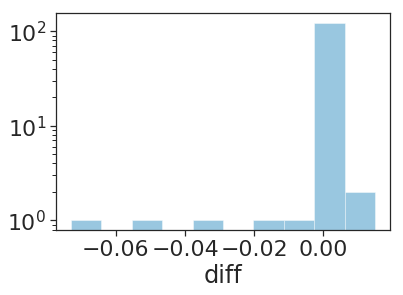

In [59]:
sns.distplot(df['diff'], kde=False, bins=10)
plt.yscale('log')

In [2]:
import pyrosetta
pyrosetta.init()

core.init: Checking for fconfig files in pwd and ./rosetta/flags
core.init: Rosetta version: 2019.01+HEAD.dbc838b6ae6 dbc838b6ae620b1293476b1bd4366ffc2facc5b5 ssh://git@github.com/RosettaCommons/main 2019-01-03T10:31:13
core.init: command: PyRosetta -ex1 -ex2aro -database /home/haddox/.conda/envs/high_throughput_design_for_E_function_opt/lib/python3.7/site-packages/pyrosetta/database
core.init: 'RNG device' seed mode, using '/dev/urandom', seed=377965120 seed_offset=0 real_seed=377965120
core.init.random: RandomGenerator:init: Normal mode, seed=377965120 RG_type=mt19937


In [3]:
pose = pyrosetta.pose_from_pdb('results/eye_test/1BUH/complex.207.pdb')

core.chemical.GlobalResidueTypeSet: Finished initializing fa_standard residue type set.  Created 636 residue types
core.chemical.GlobalResidueTypeSet: Total time to initialize 0.827293 seconds.
core.import_pose.import_pose: File 'results/eye_test/1BUH/complex.207.pdb' automatically determined to be of type PDB
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 1 atoms at position 39 in file results/eye_test/1BUH/complex.207.pdb. Best match rsd_type:  THR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] discarding 3 atoms at position 40 in file results/eye_test/1BUH/complex.207.pdb. Best match rsd_type:  THR
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 39 atom  OXT (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom for file-residue 40 atom 1H   (trying to store temperature in PDBInfo)
core.io.pose_from_sfr.PoseFromSFRBuilder: [ WARNING ] can't find pose atom

In [8]:
res = pose.residue(201)
for atom_n in range(1, res.natoms()+1):
    print(atom_n, res.atom_name(atom_n))

1  N  
2  CA 
3  C  
4  O  
5  CB 
6  CG 
7  CD 
8  OE1
9  OE2
10  H  
11  HA 
12 1HB 
13 2HB 
14 1HG 
15 2HG 
